In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
from imblearn.over_sampling import SMOTE

1. INSTALL & LOAD SASTRAWI

In [ ]:
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

stemmer = StemmerFactory().create_stemmer()
stop_words_id = StopWordRemoverFactory().get_stop_words()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/NLP/data/google_reviewapp.csv'

df = pd.read_csv(
    path,
    encoding='latin1',
    delimiter=';',
    on_bad_lines='skip'
)

df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,userName,score,at,content,translated_content,sentiment
0,Rahma Lusiana,3,2024-06-29 02:29:45,"- Durasi rekam suara dipanjangin kalo bisa, bi...",- The duration of the voice recording is exten...,positive
1,EBH Gomone,5,2024-07-15 18:20:13,Selalu tetap terhubung tersinkron dalam family...,"Always stay connected, synchronized in my fami...",positive
2,Dwi Andriani,5,2024-07-06 08:24:14,Alhamdulillah senang bisa gabung di trend dan ...,"Alhamdulillah, I'm happy to be able to join th...",positive
3,Alex Penyiar Oficial,5,2024-07-09 09:57:29,Setiap Manusia yang memiliki Jiwa Seni ia memi...,Every human being who has an artistic soul has...,positive
4,Agustinur M.H Saputri,5,2024-06-18 23:20:49,Hallo admin meta. Sejauh ini aplikasi threads ...,Hello meta admin. So far the threads applicati...,positive


Sebagai pengingat, jika Anda ingin melanjutkan dengan `df_drive` sebagai DataFrame utama Anda, Anda perlu memastikan kolom-kolom yang digunakan di sel-sel selanjutnya (`review_text`, `rating`, `thumbs_up`) ada di `df_drive`.

In [ ]:
if 'thumbs_up' not in df.columns:
    df['thumbs_up'] = 0
df = df[['content', 'score', 'thumbs_up']]
df = df.dropna(subset=['content', 'score'])


In [ ]:
# Definisi rating rendah (1 dan 2)
df['label_low_rating'] = df['score'].apply(lambda x: 1 if x <= 2 else 0)

df['label_low_rating'].value_counts()


,count
label_low_rating,
0,698
1,302


2. PREPROCESSING

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return stemmer.stem(text)

# Pastikan kolom content dan score ada
df['clean_review'] = df['content'].apply(clean_text)
df['label_low_rating'] = df['score'].apply(lambda x: 1 if x <= 2 else 0)
df['thumbs_up'] = df['thumbs_up'].fillna(0) # Isi nilai kosong dengan 0

3. SPLIT DATA (PENTING: Split DF dulu agar index sinkron)

In [ ]:
df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label_low_rating']
)

4. FEATURE EXTRACTION - MODALITY 1 (TEKS)

In [ ]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words=stop_words_id)
X_train_tfidf = tfidf.fit_transform(df_train['clean_review'])
X_test_tfidf = tfidf.transform(df_test['clean_review'])

5. FEATURE EXTRACTION - MODALITY 2 (NUMERIK)

In [ ]:
scaler = MinMaxScaler() # Gunakan MinMaxScaler agar cocok dengan TF-IDF (range 0-1)
X_train_num = scaler.fit_transform(df_train[['thumbs_up']])
X_test_num = scaler.transform(df_test[['thumbs_up']])

6. DATA FUSION (Menggabungkan Teks + Numerik)

In [ ]:
X_train_fused = hstack([X_train_tfidf, X_train_num])
X_test_fused = hstack([X_test_tfidf, X_test_num])

y_train = df_train['label_low_rating']
y_test = df_test['label_low_rating']

7. SMOTE (Balancing Data yang sudah di-Fusion)

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_fused, y_train)

# Menampilkan jumlah data untuk membuktikan data sudah seimbang
print("Jumlah data setelah SMOTE (0: Bukan Rendah, 1: Rating Rendah):")
print(pd.Series(y_resampled).value_counts())

Jumlah data setelah SMOTE (0: Bukan Rendah, 1: Rating Rendah):
label_low_rating
0    558
1    558
Name: count, dtype: int64


8. MODELING (Random Forest)

In [ ]:
rf_smote = RandomForestClassifier(n_estimators=200, random_state=42)
rf_smote.fit(X_resampled, y_resampled)

RandomForestClassifier(n_estimators=200, random_state=42)

9. EVALUASI

HASIL EVALUASI OPTIMASI (THRESHOLD 0.35):
              precision    recall  f1-score   support

           0       0.87      0.79      0.82       140
           1       0.59      0.72      0.65        60

    accuracy                           0.77       200
   macro avg       0.73      0.75      0.74       200
weighted avg       0.78      0.77      0.77       200



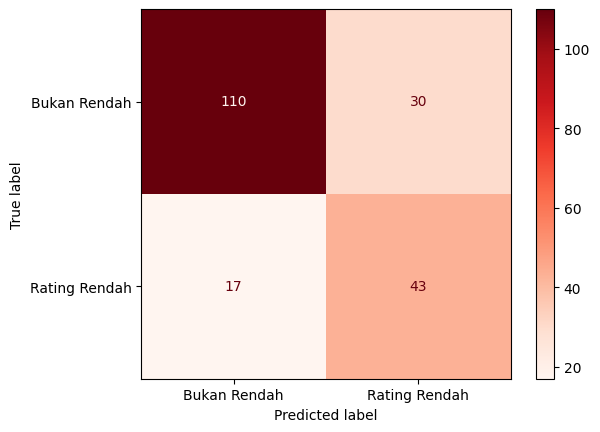

In [ ]:
# 1. Gunakan Model dengan Parameter Lebih Agresif
rf_boosted = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=1,
    random_state=42,
    class_weight='balanced'
)

# Latih ulang pada data yang sudah di-SMOTE (X_resampled sudah berisi 5001 fitur)
rf_boosted.fit(X_resampled, y_resampled)

# 2. Teknik Penyesuaian Threshold
# PERBAIKAN: Gunakan X_test_fused (5001 fitur), BUKAN X_test_tfidf (5000 fitur)
y_probs = rf_boosted.predict_proba(X_test_fused)[:, 1]

# Turunkan threshold ke 0.35 (atau sesuaikan ke 0.30 jika ingin Recall lebih tinggi)
threshold = 0.35
y_pred_75 = (y_probs >= threshold).astype(int)

# 3. Tampilkan Hasil
print(f"HASIL EVALUASI OPTIMASI (THRESHOLD {threshold}):")
print(classification_report(y_test, y_pred_75))

# 4. Visualisasi Confusion Matrix Baru
cm = confusion_matrix(y_test, y_pred_75)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bukan Rendah', 'Rating Rendah'])
disp.plot(cmap='Reds')
plt.show()

10. IDENTIFIKASI KATA PENYEBAB RATING RENDAH (Feature Importance)

Total Fitur (Teks + Numerik): 5001
Total Importance Scores: 5001


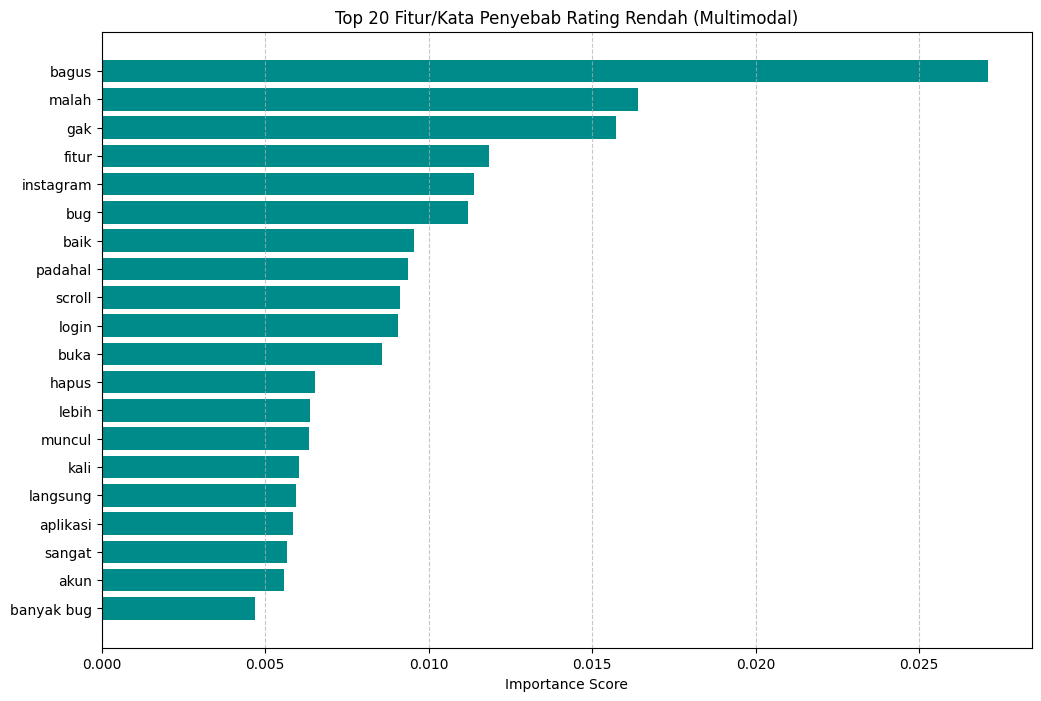

     Fitur  Kepentingan
     bagus     0.027093
     malah     0.016404
       gak     0.015732
     fitur     0.011852
 instagram     0.011395
       bug     0.011207
      baik     0.009554
   padahal     0.009360
    scroll     0.009127
     login     0.009059
      buka     0.008576
     hapus     0.006506
     lebih     0.006372
    muncul     0.006323
      kali     0.006045
  langsung     0.005931
  aplikasi     0.005856
    sangat     0.005667
      akun     0.005573
banyak bug     0.004700


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Ambil skor importance dari model
importances = rf_smote.feature_importances_

# 2. Ambil nama fitur dari TF-IDF (Modality 1: Teks)
feature_names_tfidf = list(tfidf.get_feature_names_out())

# 3. Tambahkan nama fitur numerik (Modality 2: Thumbs Up)
# Ini langkah krusial agar panjang array sama (Fusion)
all_features = feature_names_tfidf + ['thumbs_up']

# Cek sinkronisasi
print(f"Total Fitur (Teks + Numerik): {len(all_features)}")
print(f"Total Importance Scores: {len(importances)}")

# 4. Membuat DataFrame
# Jika masih ada selisih 1-2 angka karena eksperimen sebelumnya, kode ini akan memotongnya otomatis
min_len = min(len(all_features), len(importances))
feature_importance_df = pd.DataFrame({
    'Fitur': all_features[:min_len],
    'Kepentingan': importances[:min_len]
})

# 5. Urutkan dan ambil Top 20
top_20 = feature_importance_df.sort_values(by='Kepentingan', ascending=False).head(20)

# 6. Visualisasi
plt.figure(figsize=(12, 8))
plt.barh(top_20['Fitur'], top_20['Kepentingan'], color='darkcyan')
plt.gca().invert_yaxis()
plt.title('Top 20 Fitur/Kata Penyebab Rating Rendah (Multimodal)')
plt.xlabel('Importance Score')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print(top_20.to_string(index=False))

In [ ]:
from sklearn.model_selection import cross_val_score

# Melakukan validasi sebanyak 5 kali dengan lipatan data yang berbeda
cv_scores = cross_val_score(rf_smote, X_resampled, y_resampled, cv=5, scoring='recall')

print(f"Rata-rata Recall (Cross-Validation): {cv_scores.mean():.2f}")
print(f"Stabilitas Model (Standar Deviasi): {cv_scores.std():.2f}")

Rata-rata Recall (Cross-Validation): 0.85
Stabilitas Model (Standar Deviasi): 0.15


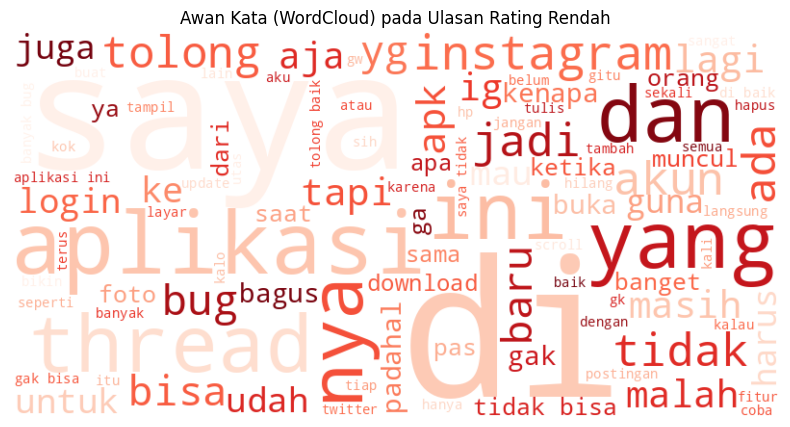

In [ ]:
from wordcloud import WordCloud

# Mengambil kata-kata yang masuk dalam kategori Rating Rendah (1 & 2)
low_rating_text = " ".join(df[df['label_low_rating'] == 1]['clean_review'])

wordcloud = WordCloud(width=800, height=400, background_color='white',
                      colormap='Reds', max_words=100).generate(low_rating_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Awan Kata (WordCloud) pada Ulasan Rating Rendah')
plt.show()